In [15]:
from collections import Counter
from functools import partial

import pandas as pd
import numpy as np
import scipy

from statsmodels.formula.api import ols

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output

%matplotlib inline

In [2]:
from sklearn.cross_validation import StratifiedShuffleSplit, ShuffleSplit

In [3]:
from libscores import r2_metric

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.regularizers import WeightRegularizer, l1, l2
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU, ELU, LeakyReLU
from keras.callbacks import EarlyStopping, Callback

In [19]:
class WatchlistCallback(Callback):
    def __init__(self, watchlist, eval_metric, epoch_no=10):
        super(Callback, self).__init__()

        self.epoch_no = epoch_no
        self.X, self.y = watchlist
        self.eval_metric = eval_metric
        self.scores = []
        self.epochs = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.epoch_no == 0:
            y_pred = self.model.predict(self.X, verbose=0)
            score = self.eval_metric(self.y, y_pred)
            self.scores.append(score)
            self.epochs.append(epoch)

            print "score: %0.6f (epoch no %d)" % (score, epoch)  

class StatusCallback(Callback):    
    def __init__(self, epoch_total):
        super(Callback, self).__init__()
        self.progress = tqdm(total=epoch_total)
        
    def on_epoch_end(self, epoch, logs={}):
        self.progress.update(1)

    def __enter__(self): 
        return self

    def __exit__(self, type, value, traceback):
        self.progress.close()

In [5]:
def read_info(file_name):
    result = []
    
    for line in file(file_name):
        key, value = line.strip().split('=')
        key = key.strip()
        value = value.strip().strip("'")
        if value.isdigit():
            value = int(value)
        result.append((key, value))
    
    return dict(result)

In [6]:
public = read_info('data/set5_yolanda/yolanda_public.info')
public

{'feat_num': 100,
 'feat_type': 'Numerical',
 'has_categorical': 0,
 'has_missing': 0,
 'is_sparse': 0,
 'label_num': 0,
 'metric': 'r2_metric',
 'name': 'yolanda',
 'target_num': 1,
 'target_type': 'Numerical',
 'task': 'regression',
 'test_num': 30000,
 'time_budget': 1200,
 'train_num': 400000,
 'usage': 'AutoML challenge 2014',
 'valid_num': 30000}

In [7]:
def read_float_dense_features(file_name):
    result = list()
    for line in file(file_name):
        row = [float(f) for f in line.strip().split(' ')]
        result.append(row)
    return np.array(result)

In [8]:
def read_numeric_labels(file_name):
    return np.fromfile(file_name, sep='\n', dtype=np.float)

In [127]:
data = 'data/set5_yolanda/yolanda_'
X = read_float_dense_features(data + 'train.data')

X_valid = read_float_dense_features(data + 'valid.data')
X_test  = read_float_dense_features(data + 'test.data')

print X.shape, y.shape
print X_valid.shape, X_test.shape

(400000, 100) (400000,)
(30000, 100) (30000, 100)


In [140]:
y = read_numeric_labels(data + 'train.solution')

In [141]:
y_mean = y.mean()
y = y.reshape(-1, 1) - y_mean

In [133]:
scaler = StandardScaler(with_mean=True, copy=False)
X = scaler.fit_transform(X)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [134]:
train_size = 0.8
EPOCHS = 500

cv = ShuffleSplit(len(y), n_iter=1, train_size=train_size, random_state=1)
train, test = next(cv.__iter__())

In [157]:
model = Sequential()

model.add(Dense(input_dim=100, output_dim=100, init='uniform'))
model.add(Activation('tanh'))

model.add(Dense(input_dim=100, output_dim=1, init='uniform'))
model.add(Activation('linear'))

model.compile(loss="mean_squared_error", optimizer="sgd") 

def eval_model(solution, prediction):
    return r2_metric(solution + y_mean, prediction + y_mean, task='regression')

watchlist = WatchlistCallback(watchlist=(X[test], y[test]), eval_metric=eval_model, epoch_no=1)

In [158]:
model.fit(X[train], y[train], nb_epoch=EPOCHS, batch_size=100000, callbacks=[watchlist], verbose=0)

score: 0.011256 (epoch no 0)
score: 0.027801 (epoch no 1)
score: 0.055176 (epoch no 2)
score: 0.090169 (epoch no 3)
score: 0.124938 (epoch no 4)
score: 0.153628 (epoch no 5)
score: 0.176280 (epoch no 6)
score: 0.193668 (epoch no 7)
score: 0.207134 (epoch no 8)
score: 0.218070 (epoch no 9)
score: 0.227016 (epoch no 10)
score: 0.234635 (epoch no 11)
score: 0.240987 (epoch no 12)
score: 0.246410 (epoch no 13)
score: 0.251111 (epoch no 14)
score: 0.255231 (epoch no 15)
score: 0.258510 (epoch no 16)
score: 0.261535 (epoch no 17)
score: 0.264075 (epoch no 18)
score: 0.266127 (epoch no 19)
score: 0.268166 (epoch no 20)
score: 0.270033 (epoch no 21)
score: 0.271641 (epoch no 22)
score: 0.273271 (epoch no 23)
score: 0.274810 (epoch no 24)
score: 0.276066 (epoch no 25)
score: 0.277246 (epoch no 26)
score: 0.278255 (epoch no 27)
score: 0.279304 (epoch no 28)
score: 0.280467 (epoch no 29)
score: 0.281431 (epoch no 30)
score: 0.282244 (epoch no 31)
score: 0.283230 (epoch no 32)
score: 0.284066 (epo

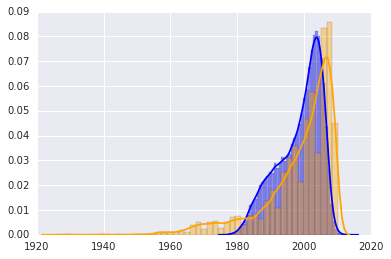

In [160]:
pred = model.predict(X[test]).reshape(-1)
sns.distplot(pred + y_mean, color='blue')
sns.distplot(y[test] + y_mean, color='orange')

In [161]:
EPOCHS = 308

model = Sequential()

model.add(Dense(input_dim=100, output_dim=100, init='uniform'))
model.add(Activation('tanh'))

model.add(Dense(input_dim=100, output_dim=1, init='uniform'))
model.add(Activation('linear'))

model.compile(loss="mean_squared_error", optimizer="sgd") 

with StatusCallback(epoch_total=EPOCHS) as status:
    model.fit(X, y, nb_epoch=EPOCHS, batch_size=100000, callbacks=[status], verbose=0)

In [162]:
y_valid = model.predict(X_valid) + y_mean
y_test = model.predict(X_test) + y_mean

In [163]:
np.savetxt('submission/yolanda_valid.predict', y_valid, fmt='%0.5f')
np.savetxt('submission/yolanda_test.predict', y_test, fmt='%0.5f')